In [1]:
%%time
### 生成输出目录的模块
import os
from datetime import datetime

def generate_output(disturb: bool, filename):
    # Generate the folder name with the current date
    now = datetime.now()
    if disturb:
        folder_name = f"Graph_Rmv_Stoch_{now.strftime('%Y-%m-%d-%H')}"
    else:
        folder_name = f"Graph_Rmv_Btwn_{now.strftime('%Y-%m-%d-%H')}"

    # Create the output directory if it doesn't exist
    output_dir = os.path.join(os.getcwd(), folder_name)
    os.makedirs(output_dir, exist_ok=True)

    # Construct the full file path
    file_path = os.path.join(output_dir, filename)

    return file_path

CPU times: user 8 µs, sys: 5 µs, total: 13 µs
Wall time: 15.5 µs


In [2]:
%%time
import os
from datetime import datetime

import networkx as nx
from networkx.generators.community import LFR_benchmark_graph

n = 1000
tau1 = 2  # Power-law exponent for the degree distribution
tau2 = 1.1  # Power-law exponent for the community size distribution
mu = 0.1  # Mixing parameter
avg_deg = 25  # Average Degree
max_deg = int(0.1 * n)  # Max Degree
min_commu = 60  # Min Community Size
max_commu = int(0.1 * n)  # Max Community Size

G0 = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=avg_deg, max_degree=max_deg, min_community=min_commu, max_community=max_commu,
    seed=7
)

# Remove multi-edges and self-loops from G0
G0 = nx.Graph(G0)
selfloop_edges = list(nx.selfloop_edges(G0))
G0.remove_edges_from(selfloop_edges)

# Generate a timestamp for the output file names
now = datetime.now()

# Write the graph's edge list to a file
edge_output_file = f"edgelist_{now.strftime('%Y-%m-%d-%H')}.txt"
nx.write_edgelist(G0, edge_output_file, delimiter=' ', data=False)

import numpy as np
# Get intrinsic membership and save it to a file
intrinsic_communities = {frozenset(G0.nodes[v]["community"]) for v in G0}
intrinsic_membership = np.empty(G0.number_of_nodes(), dtype=int)
for node in range(G0.number_of_nodes()):
    for index, inner_set in enumerate(intrinsic_communities):
        if node in inner_set:
            intrinsic_membership[node] = index
            break

membership_output_file = f"membership_{now.strftime('%Y-%m-%d-%H')}.txt"
np.savetxt(membership_output_file, intrinsic_membership, delimiter=' ', fmt='%d')

# Get betweenness centrality and save it to a file
betweenness = list(nx.betweenness_centrality(G0).values())
betweenness_output_file = f"betweenness_{now.strftime('%Y-%m-%d-%H')}.txt"
np.savetxt(betweenness_output_file, betweenness, delimiter=' ')

CPU times: user 7.09 s, sys: 7.39 s, total: 14.5 s
Wall time: 5.59 s


In [3]:
'''
### 读取存储的图的相关信息
### 从文件中读入内容并转化成 边列表
with open('edgelist_2023-07-11-17.txt', 'r') as file:
    lines = file.readlines()

### Process the lines and create a list of number pairs
edge_list = []
for line in lines:
    pair = tuple(map(int, line.strip().split()))
    edge_list.append(pair)

### Print the list of number pairs
#print(edge_list)

import networkx as nx

### 新建一个图 
G0 = nx.Graph()

### 向图添加边
G0.add_edges_from(edge_list)

### 记录有几个结点
N = G0.number_of_nodes()

### Load Community Info
import numpy as np

membership_list = "membership_2023-07-11-17.txt"
intrinsic_membership = np.loadtxt(membership_list, dtype=int)

btwn_file = "betweenness_2023-07-11-17.txt"
betweenness = np.loadtxt(btwn_file)
'''

'\n### 读取存储的图的相关信息\n### 从文件中读入内容并转化成 边列表\nwith open(\'edgelist_2023-07-11-17.txt\', \'r\') as file:\n    lines = file.readlines()\n\n### Process the lines and create a list of number pairs\nedge_list = []\nfor line in lines:\n    pair = tuple(map(int, line.strip().split()))\n    edge_list.append(pair)\n\n### Print the list of number pairs\n#print(edge_list)\n\nimport networkx as nx\n\n### 新建一个图 \nG0 = nx.Graph()\n\n### 向图添加边\nG0.add_edges_from(edge_list)\n\n### 记录有几个结点\nN = G0.number_of_nodes()\n\n### Load Community Info\nimport numpy as np\n\nmembership_list = "membership_2023-07-11-17.txt"\nintrinsic_membership = np.loadtxt(membership_list, dtype=int)\n\nbtwn_file = "betweenness_2023-07-11-17.txt"\nbetweenness = np.loadtxt(btwn_file)\n'

In [4]:
%%time
### 生成删除顶点的顺序 模块
import random
import networkx as nx
import numpy as np

def nodes_sample(G, disturb: bool, number_of_nodes: int, percent, betweenness):
    graph = G.copy()
    sample_size = int(number_of_nodes*percent)
    if disturb:
        removed_nodes = random.sample(range(number_of_nodes), sample_size)
        graph.remove_nodes_from(removed_nodes)
        if nx.is_connected(graph):
            return removed_nodes
    else: 
        removed_nodes = random.choices(range(number_of_nodes), betweenness, k=sample_size)
        graph.remove_nodes_from(removed_nodes)
        if nx.is_connected(graph):
            return removed_nodes
        
#nodes_sample(G0, N, 0.8)

import numpy as np
import json

def generate_remove_list(G, disturb: bool, number_of_nodes, betweenness):
    remove_procedure = []
    for percent in np.arange(0.05, 0.86, 0.05):
        ls = []
        while len(ls)<50:
            temp = nodes_sample(G = G, disturb = disturb, number_of_nodes = number_of_nodes, percent = percent, betweenness = betweenness)
            if not temp is None:
                ls.append(temp)
        remove_procedure.append(ls)
    filename = generate_output(disturb, "0Remove_Procedure.txt")
    with open(filename, 'w') as file:
        json.dump(remove_procedure, file)
    return remove_procedure

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 22.9 µs


In [5]:
%%time
remove_procedure = generate_remove_list(G0, True, G0.number_of_nodes(), betweenness)

### 读取存储的删除顶点的顺序信息
'''
with open('Graph_Rmv_Stoch_2023-07-11-18/remove_procedure.txt', 'r') as file:
    loaded_data = json.load(file)
loaded_data == ls
'''

CPU times: user 31.4 s, sys: 0 ns, total: 31.4 s
Wall time: 31.4 s


"\nwith open('Graph_Rmv_Stoch_2023-07-11-18/remove_procedure.txt', 'r') as file:\n    loaded_data = json.load(file)\nloaded_data == ls\n"

In [6]:
%%time
index = []
for sublist_list in remove_procedure:
    sublist_index = []
    for sublist in sublist_list:
        temp = np.ones(G0.number_of_nodes(), dtype=bool)
        temp[sublist] = False
        sublist_index.append(temp)
    index.append(sublist_index)

CPU times: user 24.5 ms, sys: 0 ns, total: 24.5 ms
Wall time: 22.2 ms


In [7]:
%%time
import os
import csv
from datetime import date

def save_SCORES_to_csv(scores, disturb: bool, filename):
    """
    Saves a list of list of list to a CSV file with a double space separator.

    Args:
        scores (list): The list of list of list to be saved.
        disturb (bool): A boolean indicating if disturbance is present.
        filename (str): The name of the output CSV file.
    """
    # Construct the full file path
    file_path = generate_output(disturb, filename + ".csv")

    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=' ')
        for outer_list in scores:
            for inner_list in outer_list:
                writer.writerow(inner_list)

CPU times: user 1.67 ms, sys: 0 ns, total: 1.67 ms
Wall time: 1.4 ms


In [8]:
%%time
import os
import csv
from datetime import date

def save_to_csv(content, disturb: bool, filename):
    """
    Saves a list of 4-lists to a CSV file with a double space separator.
    
    Args:
        scores (list): The list of 4-lists to be saved.
        filename (str): The name of the output CSV file.
    """
    # Construct the full file path
    file_path = generate_output(disturb, filename+".csv")

    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=' ')
        for content_list in content:
            writer.writerow(content_list)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 12.6 µs


In [9]:
%%time
from auxpack.eval_embd import eval_embd as EE
from clusim.clustering import Clustering

D=20
K = len(np.unique(intrinsic_membership))
wk=32

CPU times: user 320 ms, sys: 47.8 ms, total: 367 ms
Wall time: 581 ms


In [10]:
%%time
### 1 Hope 方法
from gem.embedding.hope import HOPE 

SCORES=[]

MEAN = []
STD = []

for rp, idx in zip(remove_procedure,index):
    scores = []
    for realize, idxx in zip(rp, idx):
        G=G0.copy()
        G.remove_nodes_from(realize)
        hope_model = HOPE(d=D, beta=0.01) 
        # A higher value of beta places more emphasis on capturing higher-order proximities
        embd = hope_model.learn_embedding(graph=G, is_weighted=False, no_python=True)
        intrin_list = intrinsic_membership[idxx]
        intrin_Clus = Clustering({i: [intrin_list[i]] for i in range(len(intrin_list))})
        K = len(np.unique(intrin_list))
        score = EE(K,intrin_list,intrin_Clus, embd)
        scores.append(score)
    # Convert the list to a NumPy array for efficient computations
    array = np.array(scores)
    # Calculate the mean and standard deviation for each coordinate
    mean = np.mean(array, axis=0)
    std = np.std(array, axis=0)
    print(mean,std)
    MEAN.append(mean)
    STD.append(std)
    SCORES.append(scores)

[0.94690335 0.98813939 0.87628773 0.98027024] [0.00495507 0.00838491 0.0091339  0.01920329]
[0.94426361 0.9880716  0.87200055 0.98014451] [0.00886159 0.00948718 0.01477877 0.02090365]
[0.94139397 0.98246743 0.86443998 0.97277894] [0.0070452  0.01366409 0.01501145 0.02386769]
[0.93692969 0.98056508 0.86068933 0.96895591] [0.00676189 0.01319246 0.01219669 0.02513656]
[0.93210487 0.97589806 0.85355928 0.96326469] [0.00863285 0.01517289 0.01297635 0.02440649]
[0.93233013 0.97481882 0.8534955  0.95990462] [0.00927141 0.01509639 0.013702   0.02681115]
[0.92665988 0.96982772 0.84434648 0.95321074] [0.01167627 0.01929345 0.01926633 0.03087059]
[0.92193451 0.96138923 0.83792309 0.93871934] [0.01200346 0.02239574 0.01834303 0.03572883]
[0.91201325 0.95887709 0.82000448 0.93224212] [0.01376747 0.02360298 0.02149544 0.03836622]
[0.90968721 0.95658049 0.81665162 0.92997455] [0.01373652 0.0211083  0.02256887 0.03529627]
[0.90319409 0.93820796 0.80557039 0.89979235] [0.01652841 0.02547684 0.02742305 

In [11]:
%%time
save_SCORES_to_csv(SCORES, True, "1HOPE_SCORES")
save_to_csv(MEAN, True, "1HOPE_MEAN")
save_to_csv(STD, True, "1HOPE_STD")

CPU times: user 4.42 ms, sys: 371 µs, total: 4.79 ms
Wall time: 7.15 ms


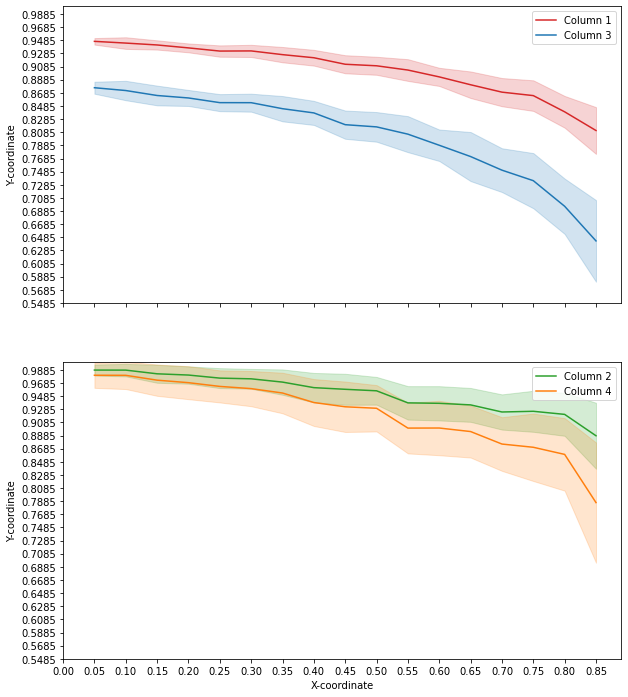

CPU times: user 825 ms, sys: 305 ms, total: 1.13 s
Wall time: 1.46 s


In [12]:
%%time
import numpy as np
import matplotlib.pyplot as plt

# Generate x-coordinates for the data points with a step size of 0.05
x_values = np.arange(0.05, 0.86, 0.05)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot the lines for columns 1 and 3 in the first subplot
ax1.plot(x_values, [MEAN[i][0] for i in range(len(MEAN))], label='Column 1', color='tab:red')
ax1.plot(x_values, [MEAN[i][2] for i in range(len(MEAN))], label='Column 3', color='tab:blue')
ax1.fill_between(x_values, np.subtract([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]),
                 np.add([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]), alpha=0.2, color='tab:red')
ax1.fill_between(x_values, np.subtract([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]),
                 np.add([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]), alpha=0.2, color='tab:blue')
ax1.set_ylabel('Y-coordinate')
ax1.legend()

# Plot the lines for columns 2 and 4 in the second subplot
ax2.plot(x_values, [MEAN[i][1] for i in range(len(MEAN))], label='Column 2', color='tab:green')
ax2.plot(x_values, [MEAN[i][3] for i in range(len(MEAN))], label='Column 4', color='tab:orange')
ax2.fill_between(x_values, np.subtract([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]),
                 np.add([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]), alpha=0.2, color='tab:green')
ax2.fill_between(x_values, np.subtract([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]),
                 np.add([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]), alpha=0.2, color='tab:orange')
ax2.set_xlabel('X-coordinate')
ax2.set_ylabel('Y-coordinate')
ax2.legend()

# Set the x-axis scale
plt.xticks(np.arange(0.0, 0.9, 0.05))

# Automatically determine the lower bound for the y-axis
y_min = min([min(y) for y in MEAN])
y_max = max([max(y) for y in MEAN])
y_range = y_max - y_min
y_offset = y_range * 0.1  # Adjust the offset as needed
y_lower = y_min - y_offset - 0.06
y_upper = 1.0
ax1.set_ylim(y_lower, y_upper)
ax2.set_ylim(y_lower, y_upper)

# Set the y-axis tick marks
y_tick_step = 0.02
y_ticks = np.arange(y_lower, y_upper, y_tick_step)
ax1.set_yticks(y_ticks)
ax2.set_yticks(y_ticks)

# Adjust the figure size
fig.set_size_inches(10, 12)  # Increase the height of the figure

##########################
filename = "1HOPE_SEPARATE"
##########################

file_path = generate_output(True, filename+".png")
plt.savefig(file_path)    

# Show the plot
plt.show()

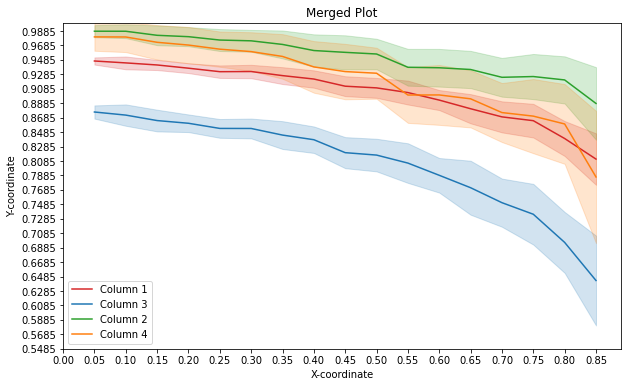

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x-coordinates for the data points with a step size of 0.05
x_values = np.arange(0.05, 0.86, 0.05)

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the lines for columns 1 and 3 in the first subplot
ax.plot(x_values, [MEAN[i][0] for i in range(len(MEAN))], label='Column 1', color='tab:red')
ax.plot(x_values, [MEAN[i][2] for i in range(len(MEAN))], label='Column 3', color='tab:blue')
ax.fill_between(x_values, np.subtract([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]),
                 np.add([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]), alpha=0.2, color='tab:red')
ax.fill_between(x_values, np.subtract([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]),
                 np.add([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]), alpha=0.2, color='tab:blue')

# Plot the lines for columns 2 and 4 in the second subplot
ax.plot(x_values, [MEAN[i][1] for i in range(len(MEAN))], label='Column 2', color='tab:green')
ax.plot(x_values, [MEAN[i][3] for i in range(len(MEAN))], label='Column 4', color='tab:orange')
ax.fill_between(x_values, np.subtract([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]),
                 np.add([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]), alpha=0.2, color='tab:green')
ax.fill_between(x_values, np.subtract([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]),
                 np.add([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]), alpha=0.2, color='tab:orange')

# Set labels and title
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_title('Merged Plot')

# Set the x-axis scale
plt.xticks(np.arange(0.0, 0.9, 0.05))

# Automatically determine the lower bound for the y-axis
y_min = min([min(y) for y in MEAN])
y_max = max([max(y) for y in MEAN])
y_range = y_max - y_min
y_offset = y_range * 0.1  # Adjust the offset as needed
y_lower = y_min - y_offset - 0.06
y_upper = 1.0
ax.set_ylim(y_lower, y_upper)

# Set the y-axis tick marks
y_tick_step = 0.02
y_ticks = np.arange(y_lower, y_upper, y_tick_step)
ax.set_yticks(y_ticks)

# Add a legend
ax.legend()

# Adjust the figure size
fig.set_size_inches(10, 6)
##########################
filename = "1HOPE_TOTAL"
##########################

file_path = generate_output(True, filename+".png")
plt.savefig(file_path)    

# Show the plot
plt.show()